# INFERNO for CMS Open Data

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
#hide
from nbdev.showdoc import *

In [3]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *
from pytorch_inferno.inferno import *

from fastcore.all import partialler
from fastcore.all import store_attr, delegates, is_close
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn.functional as F
from torch import optim, autograd, nn, Tensor
import torch
from torch.distributions import Normal

In [4]:
pd.options.mode.chained_assignment = None

## 1. Load data

In [5]:
samples = {}
for s in ["TTJets_bkg", "WZJets", "STJets", "QCD", "TTJets_signal", "Data"]:
    samples[s] = pd.read_hdf("/home/centos/data/bdt_rs5/" + s + ".h5")

In [6]:
from sklearn import preprocessing
from pytorch_inferno.data import *
import random

#features = ['ht', 'aplanarity', 'sphericity', 'chargeEta', 'MET_met', 'deltaPhiTauMet', 'mt', 'mTauJet']
features = ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']


def train_test_split(df, n = 5000):

    df.reset_index(drop=True, inplace=True)
    indices = list(df.index)
    train_id = random.sample(indices, n)
    test_id = list(set(indices) - set(train_id))
    train_mask = df.index.isin(train_id)
    test_mask = df.index.isin(test_id)
    cond = [train_mask, test_mask]
    choice = ["train", "test"]
    df['train_flag'] = np.select(cond, choice)
    
def get_cmsopen_data(samples, n_sig = 20000, n_bkg = 10000, bs=1000):
        
    #signal = samples["TTJets_signal"] #samples["TTJets_centJER_signal"] #samples["TTJets_signal_central"]
    #bkg = samples["QCD"]
    
    signal = samples["TTJets_signal"] #samples["TTJets_centJER_signal"] #samples["TTJets_signal_central"]
    bkg = samples["QCD"]
    
    train_test_split(signal, n_sig)
    train_test_split(bkg, n_bkg)
    
    print(list(signal))
    
    signal["label"] = 1
    bkg["label"] = 0
    
    signal_train = signal[signal["train_flag"] == "train"]
    signal_train["weights"] = signal_train['trigger_weight'] * signal_train['btag_weight1']
    signal_train["weights"] = signal_train["weights"] * (1. / np.mean(signal_train["weights"]))
    signal_test = signal[signal["train_flag"] == "test"]
    bkg_train = bkg[bkg["train_flag"] == "train"]
    bkg_train["weights"] = bkg_train['btag_weight2']
    bkg_train["weights"] = bkg_train["weights"] * (1. / np.mean(bkg_train["weights"]))
    bkg_test = bkg[bkg["train_flag"] == "test"]
    
    train_data = pd.concat([signal_train, bkg_train], axis=0)
    test_data = pd.concat([signal_test, bkg_test], axis=0)
    
    X_train = train_data[features].values
    # Scale
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    
    y_train = train_data["label"].values.reshape((-1,1))
    weights_train = train_data["weights"].values.reshape((-1,1))
    
    X_test = test_data[features].values
    X_test = scaler.transform(X_test)
    y_test = test_data["label"].values.reshape((-1,1))
    #weights_test= test_data["weights"]

    
    trn = (X_train, y_train) #, weights_train)
    val = (X_test, y_test)
    
    trn_dl = WeightedDataLoader(DataSet(*trn), batch_size=bs, shuffle=True, drop_last=True)
    val_dl = WeightedDataLoader(DataSet(*val), batch_size=bs, shuffle=True)
    data = DataPair(trn_dl, val_dl)
    test = DataPair(WeightedDataLoader(DataSet(*trn), batch_size=bs), 
                    WeightedDataLoader(DataSet(*val), batch_size=bs))
    
    return data, test, scaler

data, test, scaler = get_cmsopen_data(samples, n_sig = 5000, n_bkg = 5000, bs=256)

['MET_met', 'event', 'run', 'luminosityBlock', 'HLT_QuadJet40_IsoPFTau40', 'HLT_QuadJet45_IsoPFTau45', 'PV_npvs', 'genEvent_tmeme', 'norm', 'norm_up', 'norm_down', 'trigger_weight', 'trigger_weight_up', 'trigger_weight_down', 'trigger_is40', 'isSignal', 'isBkg', 'btag_weight1', 'btag_weight1_up', 'btag_weight1_down', 'btag_weight2', 'btag_weight2_up', 'btag_weight2_down', 'pdf', 'pdf_up', 'pdf_down', 'h', 'ht', 'h_jet', 'ht_jet', 'chargeEta', 'mTauJet', 'mt', 'deltaPhiTauMet', 'nJets', 'aplanarity', 'sphericity', 'train_flag', 'label', 'bdt']


## 2. BCE 

In [7]:
net_bce = nn.Sequential(nn.Linear(4,12),  nn.ReLU(),
                        nn.Linear(12,8), nn.ReLU(),
                        nn.Linear(8,1),  nn.Sigmoid())
#init_net(net)

In [8]:
model_bce = ModelWrapper(net_bce)

In [9]:
model_bce.fit(50, data=data, opt=partialler(optim.Adam), loss=nn.BCELoss(),
              cbs=[LossTracker()])

1: Train=0.6944303313891093 Valid=0.7679929555125802
2: Train=0.6744054372494037 Valid=0.7345939460989137
3: Train=0.6357877621283898 Valid=0.679681327214789
4: Train=0.5729081263908973 Valid=0.6001548110700786
5: Train=0.5057516487745138 Valid=0.5269800300533779
6: Train=0.4583151462750557 Valid=0.47793824849703964
7: Train=0.43172870843838423 Valid=0.44730049242242503
8: Train=0.4180341958999634 Valid=0.4280279673846093
9: Train=0.4103148549030989 Valid=0.41787914433248274
10: Train=0.4057755623108301 Valid=0.4143416417629181
11: Train=0.4029582624252026 Valid=0.4092950619567689
12: Train=0.40083344242511654 Valid=0.40952936613964136
13: Train=0.39984809511747116 Valid=0.40206557898449385
14: Train=0.39822647816095597 Valid=0.4083749538350211
15: Train=0.39758831873918193 Valid=0.3940213589479014
16: Train=0.39632384670086396 Valid=0.40193845613201096
17: Train=0.3957734069763086 Valid=0.39933333129885584
18: Train=0.3945802656503824 Valid=0.3971516591379502
19: Train=0.3939014635024

In [10]:
preds_bce = model_bce._predict_dl(test.val_dl)

In [11]:
df_bce = pd.DataFrame({'pred':preds_bce.squeeze()})
df_bce['gen_target'] = test.val_dl.dataset.y
df_bce.head()

,pred,gen_target
0,0.960208,1
1,0.966470,1
2,0.857027,1
3,0.981640,1
4,0.951147,1


/home/centos/env/lib64/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/centos/env/lib64/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


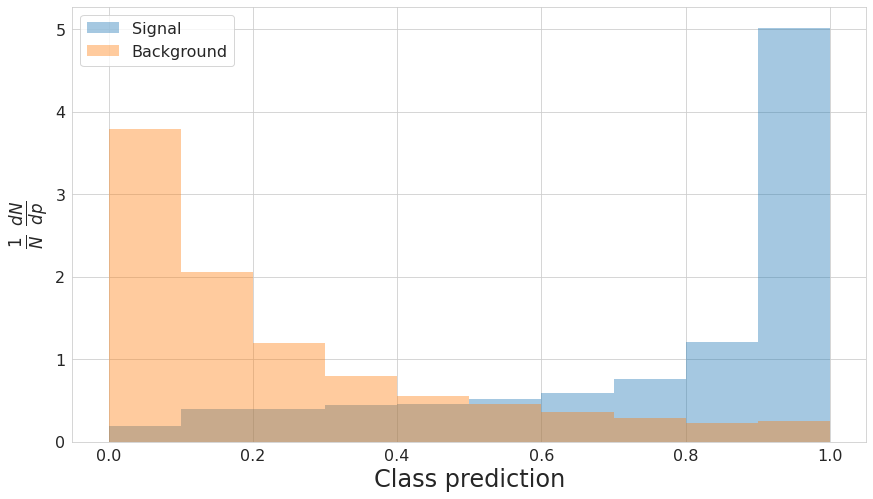

In [12]:
plot_preds(df_bce)

## 3. Train with inferno

In [13]:
class CMSOpenInferno(AbsInferno):
    r'''Inheriting class for dealing with INFERNO paper synthetic problem'''
    @delegates(AbsInferno, but=['b_shape_alpha', 's_shape_alpha'])
    def __init__(self, b_true:float=2800, mu_true:float=300, **kwargs):
        super().__init__(b_true=b_true, mu_true=mu_true, **kwargs)

    def _aug_data(self, x:Tensor) -> None:
        pass
    
net_inferno_nonn = nn.Sequential(nn.Linear(4,100),  nn.ReLU(),
                        nn.Linear(100,100), nn.ReLU(),
                        nn.Linear(100,10), VariableSoftmax(0.1))
#init_net(net)
model_inferno_nonn = ModelWrapper(net_inferno_nonn)
lt = LossTracker()
model_inferno_nonn.fit(100, data=data, opt=partialler(optim.Adam,lr=1e-3), loss=None,
                      cbs=[CMSOpenInferno(), lt])

1: Train=1061.4306343274238 Valid=794.8263518415179
2: Train=792.0332406850962 Valid=753.1937796456473
3: Train=763.0660854241787 Valid=705.3866397530692
4: Train=735.8278245192307 Valid=674.8502987234933
5: Train=725.7186827048278 Valid=674.1247105189732
6: Train=702.0796962640225 Valid=653.2334373256139
7: Train=703.0301427596654 Valid=656.215023890904
8: Train=700.1923366448818 Valid=636.0268069893973
9: Train=685.7820137219551 Valid=622.6639259556362
10: Train=694.99806252504 Valid=621.1144808523995
11: Train=675.6193722455929 Valid=633.1311936732701
12: Train=671.83888283754 Valid=618.864546421596
13: Train=659.3517111753806 Valid=605.0637979561942
14: Train=656.6796413323818 Valid=603.5904697963169
15: Train=653.1213895357572 Valid=595.8025231933593
16: Train=651.8672900077624 Valid=588.4214803641183
17: Train=640.6160380045573 Valid=582.7234587751116
18: Train=643.211420303736 Valid=592.3677301897321
19: Train=646.2742833846654 Valid=616.7803161621093
20: Train=637.9676670172275

In [14]:
class CMSOpenInferno(AbsInferno):
    r'''Inheriting class for dealing with INFERNO paper synthetic problem'''
    @delegates(AbsInferno, but=['b_shape_alpha', 's_shape_alpha'])
    def __init__(self, b_true:float=2800, mu_true:float=300, **kwargs):
        super().__init__(b_true=b_true, mu_true=mu_true, b_shape_alpha=True, 
                         n_shape_alphas=1, **kwargs)

    def _aug_data(self, x:Tensor) -> None:
        
        x[self.b_mask,0] += self.alpha[self.shape_idxs[0]]

In [15]:
net_inferno = nn.Sequential(nn.Linear(4,100),  nn.ReLU(),
                        nn.Linear(100,100), nn.ReLU(),
                        nn.Linear(100,10), VariableSoftmax(0.1))
#init_net(net)
model_inferno = ModelWrapper(net_inferno)

In [16]:
lt = LossTracker()

In [18]:
shape_aux=[Normal(0,0.5)]
model_inferno.fit(100, data=data, opt=partialler(optim.Adam,lr=1e-3), loss=None,
                  cbs=[CMSOpenInferno(shape_aux=shape_aux), lt])

1: Train=1240.5667849809695 Valid=845.1743976702008
2: Train=810.2691431290065 Valid=806.9039904785157
3: Train=788.7434754982972 Valid=770.8526759556362
4: Train=764.6871791741787 Valid=757.15732195173
5: Train=753.3924857897637 Valid=727.8375484793527
6: Train=741.1129627716847 Valid=710.7454523577009
7: Train=731.4101797250601 Valid=701.3631454031809
8: Train=720.0929972330729 Valid=689.4262663922991
9: Train=706.6441634740585 Valid=686.7608884974888
10: Train=707.1173479129106 Valid=684.8019288853236
11: Train=701.1901229467147 Valid=661.7459807477678
12: Train=693.7002751277043 Valid=677.4671843610491
13: Train=708.5690691043169 Valid=673.6915630231584
14: Train=692.1345793895232 Valid=656.9863506208147
15: Train=692.1022511017628 Valid=670.4750903320313
16: Train=687.4406268780048 Valid=653.408312639509
17: Train=683.3737057416866 Valid=668.8049408830915
18: Train=694.8106298202123 Valid=647.654203578404
19: Train=674.3614486303085 Valid=639.8473266601562
20: Train=684.2468660794

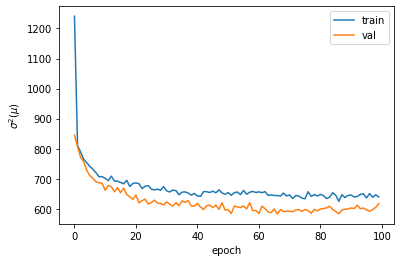

In [19]:
plt.plot(lt.losses["trn"], label="train")
plt.plot(lt.losses["val"], label="val")
plt.ylabel(r"$\sigma^2(\mu)$")
plt.xlabel(r"epoch")
plt.legend(loc="upper right")

In [129]:
class InfernoPred(PredHandler):
    r'''Prediction handler for hard assignments'''
    def get_preds(self) -> np.ndarray: return np.argmax(self.preds, 1)

In [130]:
preds_inferno = model_inferno._predict_dl(test.val_dl, pred_cb=InfernoPred())

In [131]:
df_inferno = pd.DataFrame({'pred':preds_inferno})
df_inferno['gen_target'] = test.val_dl.dataset.y
df_inferno.head()

,pred,gen_target
0,2,1
1,2,1
2,4,1
3,6,1
4,3,1


/home/centos/env/lib64/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/centos/env/lib64/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


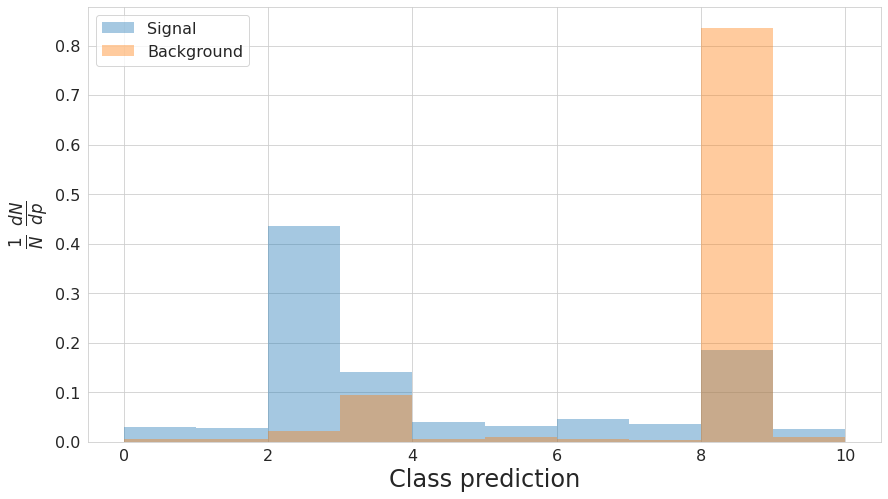

In [132]:
plot_preds(df_inferno, bin_edges=np.linspace(0,10,11))

## 3. Artificial systematics

In [27]:
import copy

In [73]:
def shift(X, y, shift, label = 0, axis=0):
    X_var = copy.deepcopy(X)
    mask = y==label
    mask = mask.squeeze()
    print(mask.shape)
    print(X_var.shape)
    X_var[mask,0] += shift
    return X_var

In [74]:
X = test.val_dl.dataset.x
y = test.val_dl.dataset.y

In [75]:
X_up = shift(X, y, 0.5, label = 0, axis=0)
X_down = shift(X, y, -0.5, label = 0, axis=0)

(44746,)
(44746, 4)
(44746,)
(44746, 4)


(array([1.886e+03, 5.305e+03, 8.869e+03, 7.785e+03, 6.026e+03, 4.449e+03,
        3.215e+03, 2.357e+03, 1.692e+03, 1.105e+03, 8.200e+02, 4.670e+02,
        3.500e+02, 1.940e+02, 1.170e+02, 6.200e+01, 3.800e+01, 5.000e+00,
        3.000e+00, 1.000e+00]),
 array([-1.68433838, -1.27054278, -0.85674718, -0.44295158, -0.02915598,
         0.38463962,  0.79843522,  1.21223082,  1.62602642,  2.03982202,
         2.45361761,  2.86741321,  3.28120881,  3.69500441,  4.10880001,
         4.52259561,  4.93639121,  5.35018681,  5.76398241,  6.17777801,
         6.59157361]),
 <BarContainer object of 20 artists>)

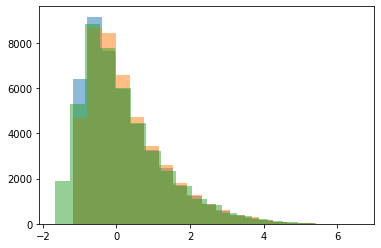

In [76]:
plt.hist(X[:,0], bins=20, alpha=0.5)
plt.hist(X_up[:,0], bins=20, alpha=0.5)
plt.hist(X_down[:,0], bins=20, alpha=0.5)

In [117]:
df_bce["pred_up"] = model_bce._predict_dl(WeightedDataLoader(DataSet(X_up, None, None), batch_size=256))
df_bce["pred_down"] = model_bce._predict_dl(WeightedDataLoader(DataSet(X_down, None, None), batch_size=256))

In [118]:
df_inferno["pred_up"] = model_inferno._predict_dl(WeightedDataLoader(DataSet(X_up, None, None), batch_size=256), pred_cb=InfernoPred())
df_inferno["pred_down"] = model_inferno._predict_dl(WeightedDataLoader(DataSet(X_down, None, None), batch_size=256), pred_cb=InfernoPred())

In [119]:
def plot_var(df, label):
    plt.hist(df[df["gen_target"]==label]["pred_up"], alpha=0.5, label="up", density=True)
    plt.hist(df[df["gen_target"]==label]["pred"], alpha=0.5, label="nominal", density=True)
    plt.hist(df[df["gen_target"]==label]["pred_down"], alpha=0.5, label="down", density=True)
    plt.legend(loc="upper right")
    plt.show()

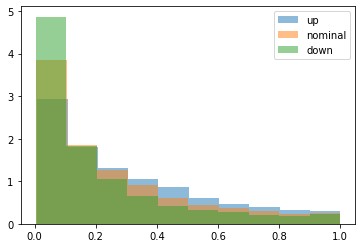

In [120]:
plot_var(df_bce, 0)

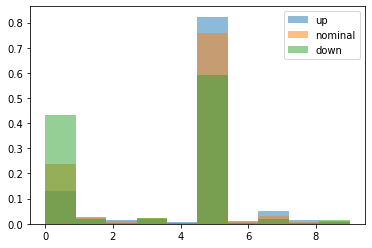

In [121]:
plot_var(df_inferno, 0)

## 4. Store predictions

In [28]:
def shift_pred(X, shift):
    X_var = copy.deepcopy(X)
    X_var[:,0] += shift
    return X_var

In [34]:
def pred_samples(model, name):

    for s in samples:

        X = samples[s][features].values
        X = scaler.transform(X)
        loader = WeightedDataLoader(DataSet(X, None, None), batch_size=256)
        if name == "bce":
            samples[s][name] = model._predict_dl(loader)
        else:
            samples[s][name] = model._predict_dl(loader, pred_cb=InfernoPred())

        if s == "QCD":
            X_up = shift_pred(X,0.5)
            X_down = shift_pred(X, -0.5)
            if name == "bce":
                samples[s][name + "_up"] = model._predict_dl(WeightedDataLoader(DataSet(X_up, None, None), batch_size=256))
                samples[s][name + "_down"] = model._predict_dl(WeightedDataLoader(DataSet(X_down, None, None), batch_size=256))                
            else:
                samples[s][name + "_up"] = model._predict_dl(WeightedDataLoader(DataSet(X_up, None, None), batch_size=256), pred_cb=InfernoPred())
                samples[s][name + "_down"] = model._predict_dl(WeightedDataLoader(DataSet(X_down, None, None), batch_size=256), pred_cb=InfernoPred())

In [35]:
pred_samples(model_bce, "bce")

In [38]:
samples["QCD"]["bce_down"]

0        0.039839
1        0.371840
2        0.246228
3        0.039545
4        0.095067
           ...   
11171    0.315371
11172    0.135686
11173    0.088991
11174    0.146870
11175    0.014055
Name: bce_down, Length: 11176, dtype: float32

In [39]:
pred_samples(model_inferno_nonn, "inferno_nonn")

In [41]:
pred_samples(model_inferno_nonn, "inferno")

In [45]:
outpath = "/home/centos/data/inferno"
for s in samples:
    samples[s].to_hdf(outpath + "/" + s + ".h5", "frame")